In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.kernel_approximation import Nystroem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [7]:
# Load data
path = os.path.join('clean_combined_toronto_property_data.xlsx')

if not os.path.exists(path):
    print(f"File not found: {path}")
else:
    data = pd.read_excel(path)

# Handle extreme outliers in price
# define outliers as values that are 3 standard deviations away from the mean
upper_limit = data["price"].mean() + 3 * data["price"].std()
lower_limit = data["price"].mean() - 3 * data["price"].std()
data = data[(data["price"] >= lower_limit) & (data["price"] <= upper_limit)]

# Add new features and normalize

# since our data contains values of region, adress, bedrooms, bathrooms, price and pricem
# we can create new features such as price_per_bedroom and price_per_bathroom
# to see if they have any effect on the price of the property
data["price_per_bedroom"] = data["pricem"] / data["bedrooms"].replace(0, np.nan)
data["price_per_bathroom"] = data["pricem"] / data["bathrooms"].replace(0, np.nan)

# Fill NaN values caused by zero bedrooms or bathrooms
# NaN（not a number） is a value that is not a number, it is a placeholder for missing values
data["price_per_bedroom"] = data["price_per_bedroom"].fillna(0)
data["price_per_bathroom"] = data["price_per_bathroom"].fillna(0)

# Normalize new features to reduce the effect of extreme values
data["price_per_bedroom"] = (data["price_per_bedroom"] - data["price_per_bedroom"].mean()) / data["price_per_bedroom"].std()
data["price_per_bathroom"] = (data["price_per_bathroom"] - data["price_per_bathroom"].mean()) / data["price_per_bathroom"].std()

# Define features and target
# we will use region, bedrooms, bathrooms, price_per_bedroom and price_per_bathroom as features
X = data[["region", "bedrooms", "bathrooms", "price_per_bedroom", "price_per_bathroom"]]
y = data["pricem"]

# Preprocessing pipeline
# we will use one-hot encoding to encode the region feature which allows model to understand the categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), ["region"])
    ],
    remainder="passthrough"
)

# Train-test split
# we will split the data into training of 80% and testing of 20%
# random_state is set to 42 to ensure reproducibility of the results
# no need to use validation set since we will use cross-validation in hyperparameter tuning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# random forest

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest pipeline
# we will use Random Forest Regressor as our model，which is an ensemble learning method；
# ensemble learning is a technique that combines multiple models to produce a stronger model.
# Random Forest is an ensemble learning method that uses multiple decision trees to make predictions；
# it is robust to overfitting and can handle large datasets with high dimensionality；
# it is suitable for regression tasks and can capture non-linear relationships between features and target

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(random_state=42))
])

# Hyperparameter grid for Random Forest
param_grid_rf = {
    "model__n_estimators": [100, 200, 500], # number of trees in the forest
    "model__max_depth": [None, 10, 20, 30], # maximum depth of the tree
    "model__min_samples_split": [2, 5, 10], # minimum number of samples required to split an internal
    "model__min_samples_leaf": [1, 2, 4] # minimum number of samples required to be at a leaf node
}

# RandomizedSearchCV for Random Forest
# we will use RandomizedSearchCV to tune the hyperparameters of the Random Forest model
# RandomizedSearchCV is a technique that randomly samples hyperparameters from a grid of hyperparameters
random_search_rf = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_grid_rf, 
    scoring="r2",
    n_iter=50,# total combinations is 3*4*3*3=108, we will randomly sample 50 combinations
    cv=5, # 5-fold cross-validation, which means the data will be split into 5 parts, and the model will be trained on 4 parts and tested on 1 part
    n_jobs=-1,
    random_state=42 # for reproducibility
)

# Fit Random Forest model
random_search_rf.fit(X_train, y_train)

# Evaluate Random Forest model
# we will evaluate the Random Forest model using Mean Squared Error (MSE) and R2 score
# Mean Squared Error (MSE) = 1/n * Σ(y_true - y_pred)^2,
# is a measure of the average squared difference between the predicted and actual values;
# R2 score = 1 - Σ(y_true - y_pred)^2 / Σ(y_true - y_mean)^2,
# is a measure of how well the model explains the variance in the data，it ranges from 0 to 1;
best_model_rf = random_search_rf.best_estimator_
rf_predictions = best_model_rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
print(f"Random Forest - MSE: {rf_mse:.4f}, R2: {rf_r2:.4f}")

# get the best hyperparameters of the Random Forest model
best_params_rf = random_search_rf.best_params_
print("During the hyperparameter tuning process, we choose the following hyperparameters:")
print(f"1. n_estimators: {best_params_rf['model__n_estimators']}")
print(f"2. max_depth: {best_params_rf['model__max_depth']}")
print(f"3. min_samples_split: {best_params_rf['model__min_samples_split']}")
print(f"4. min_samples_leaf: {best_params_rf['model__min_samples_leaf']}")

Random Forest - MSE: 0.0103, R2: 0.9830
During the hyperparameter tuning process, we choose the following hyperparameters:
1. n_estimators: 100
2. max_depth: 30
3. min_samples_split: 2
4. min_samples_leaf: 1


# svm

In [ ]:
# SVM Pipeline
# we will use Support Vector Machine (SVM) as our model, which is a powerful model for regression tasks；
# 
svm_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),  
    ("scaler", StandardScaler()), 
    ("model", SVR(kernel="rbf")) # rbf kernel is used for non-linear regression tasks
])

# Hyperparameter grid for SVM
param_grid_svm = {
    "model__C": [0.1, 1, 10, 100, 1000], # regularization parameter,which controls the trade-off between a smooth decision boundary and classifying the training points correctly
    "model__gamma": [0.001, 0.01, 0.1, 1, 10], # kernel coefficient for rbf kernel, which controls the influence of a single training example
    "model__epsilon": [0.1, 0.2, 0.5] # epsilon in the epsilon-SVR model, which specifies the epsilon-tube within which no penalty is associated in the training loss function
}

# RandomizedSearchCV for SVM
random_search_svm = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=param_grid_svm,
    scoring="r2",
    n_iter=50, # total combinations is 5*5*3=75, we will randomly sample 50 combinations
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search_svm.fit(X_train, y_train)

# Evaluate the model
best_model_svm = random_search_svm.best_estimator_
svm_predictions = best_model_svm.predict(X_test)
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_r2 = r2_score(y_test, svm_predictions)

print(f"SVM - MSE: {svm_mse:.4f}, R2: {svm_r2:.4f}")
print("Best Hyperparameters:", random_search_svm.best_params_)

SVM - MSE: 0.0162, R2: 0.9732
Best Hyperparameters: {'model__gamma': 0.01, 'model__epsilon': 0.1, 'model__C': 1000}


# polynomial regression

In [ ]:
from sklearn.linear_model import Ridge
# Polynomial Regression Pipeline
# we will use Polynomial Regression as our model, which is a linear regression model that 
# uses polynomial features to capture non-linear relationships between features and target

poly_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),  
    ("scaler", StandardScaler()),  
    ("poly_features", PolynomialFeatures()),  # polynomial features
    ("model", Ridge())  # Ridge regression, a linear regression model uses L2 regularization, it can prevent overfitting
])


param_grid_poly = {
    "poly_features__degree": [2, 3], # degree of the polynomial features
    "model__alpha": [0.01, 0.1, 1, 10, 100]  # regularization strength used in Ridge regression
}

# 
random_search_poly = RandomizedSearchCV(
    estimator=poly_pipeline,
    param_distributions=param_grid_poly,
    scoring="r2",  
    n_iter=10,  # total combinations is 4*5=20, we will randomly half of them
    cv=5, 
    n_jobs=-1,  
    random_state=42
)

# Fit the model
random_search_poly.fit(X_train, y_train)
# Evaluate the model
best_model_poly = random_search_poly.best_estimator_
poly_predictions = best_model_poly.predict(X_test)
poly_mse = mean_squared_error(y_test, poly_predictions)
poly_r2 = r2_score(y_test, poly_predictions)
# print the results
print(f"Polynomial Regression - MSE: {poly_mse:.4f}, R2: {poly_r2:.4f}")
print("Best Hyperparameters:")
print(f"1. Degree: {random_search_poly.best_params_['poly_features__degree']}")
print(f"2. Alpha: {random_search_poly.best_params_['model__alpha']}")

## visualization and comparation

Model Performance Comparison:
                   Model       MSE  R2 Score
0          Random Forest  0.010266  0.983026
1                    SVM  0.016237  0.973153
2  Polynomial Regression  0.016786  0.972245


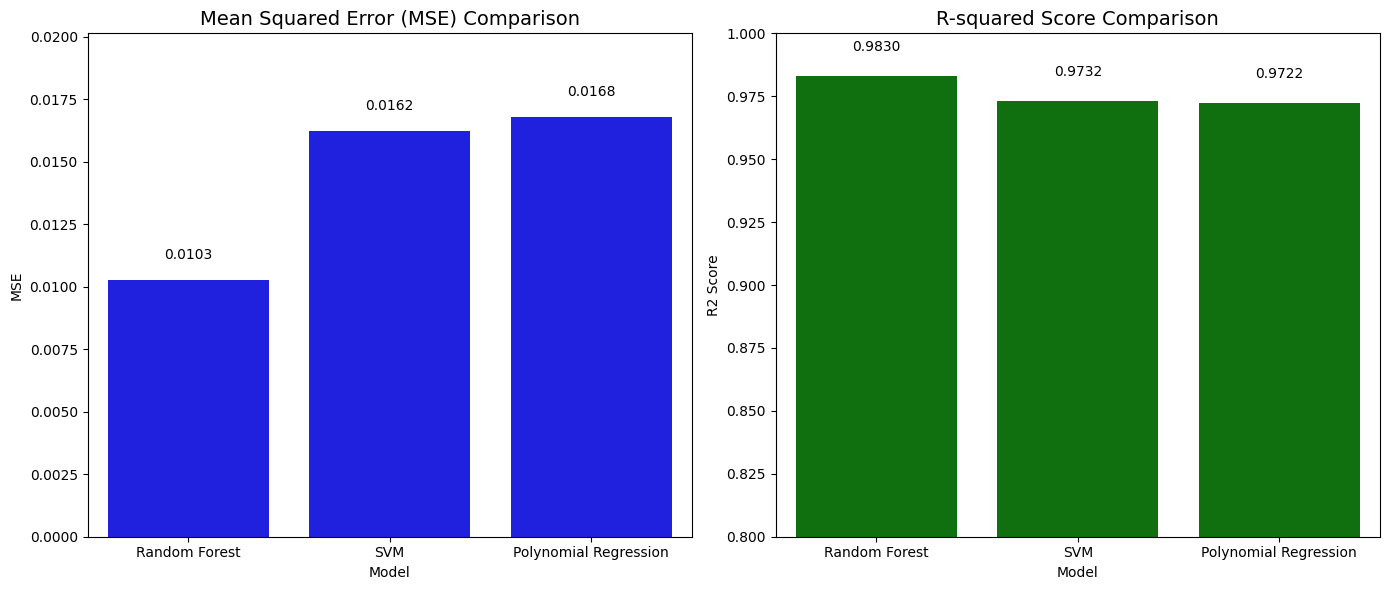

In [29]:
results = pd.DataFrame({
    "Model": ["Random Forest", "SVM", "Polynomial Regression"],
    "MSE": [rf_mse, svm_mse, poly_mse],
    "R2 Score": [rf_r2, svm_r2, poly_r2]
}
)
# print the results
print("Model Performance Comparison:")
print(results)

# Plot the results
plt.figure(figsize=(14, 6))

# mse results
plt.subplot(1, 2, 1)
sns.barplot(x="Model", y="MSE", data=results, color="blue")
plt.title("Mean Squared Error (MSE) Comparison", fontsize=14)
plt.ylabel("MSE")
plt.xlabel("Model")
plt.ylim(0, max(results["MSE"]) * 1.2)
for index, row in results.iterrows():
    plt.text(index, row["MSE"] + max(results["MSE"]) * 0.05, f'{row["MSE"]:.4f}', ha='center')

# r2 score results
plt.subplot(1, 2, 2)
sns.barplot(x="Model", y="R2 Score", data=results, color="green")
plt.title("R-squared Score Comparison", fontsize=14)
plt.ylabel("R2 Score")
plt.xlabel("Model")
plt.ylim(0.8, 1.0)
for index, row in results.iterrows():
    plt.text(index, row["R2 Score"] + 0.01, f'{row["R2 Score"]:.4f}', ha='center')

plt.tight_layout()
plt.show()

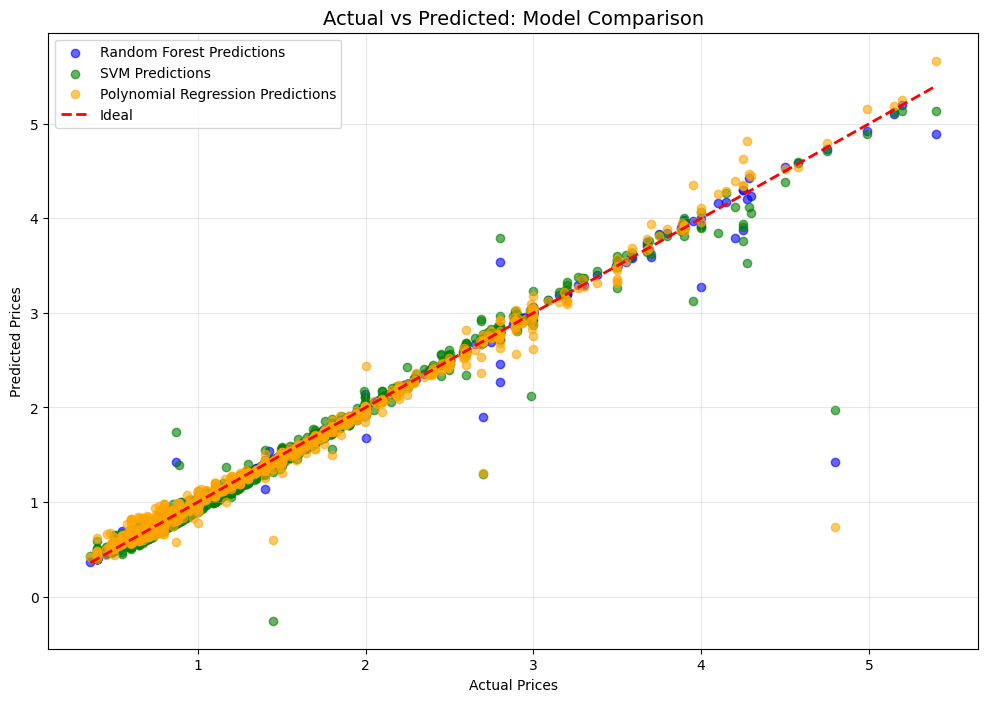

Comparison of Actual and Predicted Prices (First 10 Samples):
   Actual Price  Random Forest Prediction  SVM Prediction  \
0         1.889                     1.889           1.844   
1         1.000                     1.002           0.919   
2         2.799                     2.798           2.867   
3         1.479                     1.479           1.399   
4         0.560                     0.560           0.613   
5         1.450                     1.422          -0.255   
6         0.900                     0.900           0.820   
7         4.300                     4.236           4.058   
8         2.499                     2.499           2.509   
9         0.749                     0.749           0.777   

   Polynomial Regression Prediction  
0                             1.842  
1                             0.906  
2                             2.807  
3                             1.454  
4                             0.651  
5                             0.595  


In [32]:
# Plot the actual vs predicted prices
y_test_values = y_test.values  # ACTUAL PRICES
rf_predictions = rf_predictions 
svm_predictions = svm_predictions  
poly_predictions = poly_predictions  

plt.figure(figsize=(12, 8))

# Random Forest 
plt.scatter(y_test_values, rf_predictions, alpha=0.6, label="Random Forest Predictions", color="blue")
# SVM 
plt.scatter(y_test_values, svm_predictions, alpha=0.6, label="SVM Predictions", color="green")
# Polynomial Regression 
plt.scatter(y_test_values, poly_predictions, alpha=0.6, label="Polynomial Regression Predictions", color="orange")
# Ideal
plt.plot([y_test_values.min(), y_test_values.max()], [y_test_values.min(), y_test_values.max()], 'r--', lw=2, label="Ideal")

plt.title("Actual vs Predicted: Model Comparison", fontsize=14)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

comparison_df = pd.DataFrame({
    "Actual Price": y_test_values[:10],  # first 10 samples
    "Random Forest Prediction": rf_predictions[:10],
    "SVM Prediction": svm_predictions[:10],
    "Polynomial Regression Prediction": poly_predictions[:10]
})

comparison_df = comparison_df.round(3)

print("Comparison of Actual and Predicted Prices (First 10 Samples):")
print(comparison_df)